In [33]:
import tensorflow as tf
import numpy as py
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
import urllib.request
import os
import warnings
warnings.simplefilter(action='ignore', category=Warning)

dataset_url='https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv'
dataset_folder='./datasets/'
dataset_path='datasets/titanic3.csv'

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)
if not os.path.isfile(dataset_path):
    result=urllib.request.urlretrieve(dataset_url,dataset_path)
    print('download:',result)
else: print(dataset_path,'already exists')

datasets/titanic3.csv already exists


In [34]:
df=pd.read_csv(dataset_path)
selected_cols=['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
df_selected=df[selected_cols]

'''
df_selected.isnull().sum()
df_selected[df_selected.isnull().values==True]
'''

'\ndf_selected.isnull().sum()\ndf_selected[df_selected.isnull().values==True]\n'

In [35]:
df_selected=df_selected.sample(frac=1)
df_selected['age']=df_selected['age'].fillna(df_selected['age'].mean())
df_selected['fare']=df_selected['fare'].fillna(df_selected['fare'].mean())
df_selected['embarked']=df_selected['embarked'].fillna('S')
df_selected['embarked']=df_selected['embarked'].map({'C':0,'Q':1,'S':2}).astype(int)
df_selected['sex']=df_selected['sex'].map({'female':0,'male':1}).astype(int)
df_selected=df_selected.drop(['name'],axis=1)

In [36]:
feature=df_selected.values[:,1:]
label=df_selected.values[:,0]
featured=preprocessing.MinMaxScaler(feature_range=(0,1)).fit_transform(feature)

train_num=int(len(feature)*0.8)
train_feature=feature[:train_num]
train_label=label[:train_num]
test_feature=feature[train_num:]
test_label=label[train_num:]

In [37]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=64,input_dim=7,use_bias=True,kernel_initializer='uniform',bias_initializer='zeros',activation='relu'))
model.add(tf.keras.layers.Dense(units=32,activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(0.003),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                512       
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_history=model.fit(x=train_feature,y=train_label,validation_split=0.2,epochs=20,batch_size=50,verbose=0)

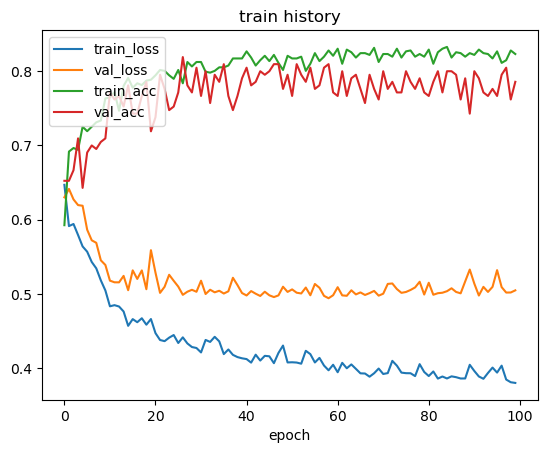

In [39]:
def show_train_history(model_history,train_loss,val_loss,train_acc,val_acc):
    plt.plot(model_history.history[train_loss])
    plt.plot(model_history.history[val_loss])
    plt.plot(model_history.history[train_acc])
    plt.plot(model_history.history[val_acc])
    plt.title('train history')
    plt.xlabel('epoch')
    plt.legend(['train_loss','val_loss','train_acc','val_acc'],loc='upper left')
    plt.show()

show_train_history(model_history,'loss','val_loss','accuracy','val_accuracy')

In [40]:
test_loss,test_acc=model.evaluate(x=test_feature,y=test_label)


9/9 [==============================] - 0s 1ms/step - loss: 0.4902 - accuracy: 0.8206


In [42]:
surv_probability=model.predict(feature)
df_selected.insert(len(df_selected.columns),'surv_probability',surv_probability)
df_selected.head(5)

41/41 [==============================] - 0s 865us/step


,survived,pclass,sex,age,sibsp,parch,fare,embarked,surv_probability
1040,1,3,0,24.000000,0,0,7.7500,1,0.543398
901,0,3,0,29.881138,1,2,23.4500,2,0.286454
729,0,3,1,35.000000,0,0,7.8958,2,0.054129
103,1,1,0,38.000000,0,0,227.5250,0,0.842165
13,1,1,0,26.000000,0,0,78.8500,2,0.976761
